<a href="https://colab.research.google.com/github/ritwiks9635/Object_Recognition_And_Detection-/blob/main/yolov5_v8_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Install the Kaggle library

In [ ]:
!pip install kaggle

In [ ]:
#Set Kaggle Configuration
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/kaggle/'

In [ ]:
# prompt: import kaggle.json file from my device

from google.colab import files
uploaded = files.upload()


In [ ]:
# prompt: make "kaggle" folder with os library and move kaggle.json to kaggle folder with shutil library

import os
import shutil

# Create the "kaggle" folder
!mkdir /content/kaggle

# Move the kaggle.json file to the "kaggle" folder
shutil.move("/content/kaggle.json", "/content/kaggle/kaggle.json")


'/content/kaggle/kaggle.json'

## Prepare dataset

In [ ]:
#download the dataset from Kaggle using the Kaggle API
!kaggle datasets download -d alincijov/self-driving-cars



 99% 884M/892M [00:06<00:00, 117MB/s]

100% 892M/892M [00:06<00:00, 137MB/s]


In [ ]:
import zipfile

# Define the path to your zip file
file_path = '/content/self-driving-cars.zip'  # Replace 'your_file.zip' with your file's name

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/kaggle')  # Replace 'destination_folder' with your desired folder

# **YOLOv5**

In [ ]:
!python -m pip install --upgrade pip

!pip install tensorflow

!pip install tensorboard

In [ ]:
!pip install torch

In [ ]:
import torch
from IPython.display import Image
import random
import shutil

### Specify the destination directory

In [ ]:
destination_directory = '/content/kaggle'

### Clone the YOLOv5 repository:

In [ ]:
%cd {destination_directory}

/content/kaggle


In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo

/content/kaggle

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [ ]:
%cd yolov5

/content/kaggle/yolov5


In [ ]:
!pip install -r requirements.txt

#### **Convert** labels(.csv) to labels(.txt) for Yolov5 standard

In [ ]:
import pandas as pd
import os

In [ ]:
image_width = 480
image_height = 300

# Replace 'path_to_your_csv.csv' with the actual path to your CSV file
csv_path = '/content/kaggle/labels_trainval.csv'

# Read CSV file into a pandas DataFrame
df = pd.read_csv(csv_path)

# Create a dictionary to store annotations for each image
annotations_dict = {}

# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    frame = row['frame']
    class_id = row['class_id']
    xmin, xmax, ymin, ymax = row['xmin'], row['xmax'], row['ymin'], row['ymax']

    # Calculate YOLO format values
    width = (xmax - xmin)/image_width
    height = (ymax - ymin)/image_height
    x_center = ((xmax + xmin) / 2)/image_width
    y_center = ((ymax + ymin) / 2)/image_height

    # Create or append to the annotations for the image
    if frame not in annotations_dict:
        annotations_dict[frame] = []
    annotations_dict[frame].append(f"{class_id} {x_center} {y_center} {width} {height}")

# Define the output folder for YOLO format files
output_folder = '/content/kaggle/labels'
os.makedirs(output_folder, exist_ok=True)

# Write YOLO format files
count_txt_val = 0
for frame, annotations in annotations_dict.items():
    output_path = os.path.join(output_folder, os.path.splitext(frame)[0] + '.txt')
    count_txt_val+=1
    with open(output_path, 'w') as file:
        for annotation in annotations:
            file.write(annotation + '\n')

print("Conversion complete.")
print(count_txt_val)

Conversion complete.

22241


In [ ]:
# count total Image dataset and check with number of txt file
import glob

# Path to the directory containing images
image_folder = '/content/kaggle/images'

# Using glob to find all files with the .jpg extension
jpg_files = glob.glob(image_folder + '/*.jpg')

# Counting the number of files with the .jpg extension
num_jpg_files = len(jpg_files)

print(f"Number of files with the .jpg extension: {num_jpg_files}")

if count_txt_val==num_jpg_files:
  print("number of images and labels is equal")
else:
  print ("number of images and labels is'nt equal")

Number of files with the .jpg extension: 22241

number of images and labels is equal


### make foldering dataset for yolov5 standard

In [ ]:
import os
import random
from concurrent.futures import ProcessPoolExecutor

# Define paths
images_folder = '/content/kaggle/images'
labels_folder = '/content/kaggle/labels'
train_folder = '/content/kaggle/yolov5/data/images/train/'
validation_folder = '/content/kaggle/yolov5/data/images/validation/'

# Get lists of images and labels
images = os.listdir(images_folder)
labels = os.listdir(labels_folder)

# Split images and labels into train and validation sets
split_ratio = 0.8
images_to_train = [image for image in images if random.random() < split_ratio]
images_to_validate = list(set(images) - set(images_to_train))
labels_to_train = [label for label in labels if label.split('.')[0] in images_to_train]  # Match labels to images
labels_to_validate = list(set(labels) - set(labels_to_train))

# Make sure destination folders exist
for folder in [train_folder, validation_folder]:
  os.makedirs(os.path.join(folder, 'images'), exist_ok=True)
  os.makedirs(os.path.join(folder, 'labels'), exist_ok=True)

# Define a function to copy a single image and label pair
def copy_file(source_image, source_label, destination_images, destination_labels):
  shutil.copyfile(os.path.join(images_folder, source_image), os.path.join(destination_images, source_image))
  shutil.copyfile(os.path.join(labels_folder, source_label), os.path.join(destination_labels, source_label))

# Use multiprocessing to copy files in parallel
with ProcessPoolExecutor() as executor:
  tasks = []

  # Prepare tasks for train set
  for image in images_to_train:
    label = image.replace('.jpg', '.txt')
    tasks.append(executor.submit(copy_file, image, label, os.path.join(train_folder, 'images'), os.path.join(train_folder, 'labels')))

  # Prepare tasks for validation set
  for image in images_to_validate:
    label = image.replace('.jpg', '.txt')
    tasks.append(executor.submit(copy_file, image, label, os.path.join(validation_folder, 'images'), os.path.join(validation_folder, 'labels')))

  # Wait for all tasks to finish
  for future in tasks:
    future.result()

print("File copying completed!")


File copying completed!


In [ ]:
# count number of file to thease destination:

# train_folder = '/content/gdrive/MyDrive/kaggle/yolov5/data/images/train/'
# validation_folder = '/content/gdrive/MyDrive/kaggle/yolov5/data/images/validation/'

# Count number of files in train and validation folders
num_train_images = len(os.listdir(os.path.join(train_folder, 'images')))
num_train_labels = len(os.listdir(os.path.join(train_folder, 'labels')))
num_validation_images = len(os.listdir(os.path.join(validation_folder, 'images')))
num_validation_labels = len(os.listdir(os.path.join(validation_folder, 'labels')))

# Print the counts
print(f"Number of training images: {num_train_images}")
print(f"Number of training labels: {num_train_labels}")
print(f"Number of validation images: {num_validation_images}")
print(f"Number of validation labels: {num_validation_labels}")


Number of training images: 17746

Number of training labels: 17746

Number of validation images: 4495

Number of validation labels: 4495


In [ ]:
# check randomly in train and validation folders, that copied the same name of ".jpg" and ".txt" file to the same folder

import random

# Define the folders to check
train_images_folder = '/content/kaggle/yolov5/data/images/train/images'
train_labels_folder = '/content/kaggle/yolov5/data/images/train/labels'
validation_images_folder = '/content/kaggle/yolov5/data/images/validation/images'
validation_labels_folder = '/content/kaggle/yolov5/data/images/validation/labels'

# Get lists of files in each folder
train_images = os.listdir(train_images_folder)
train_labels = os.listdir(train_labels_folder)
validation_images = os.listdir(validation_images_folder)
validation_labels = os.listdir(validation_labels_folder)

# Check 10 random files in train folder
for _ in range(10):
  # Choose a random image
  image_index = random.randint(0, len(train_images) - 1)
  image_filename = train_images[image_index]

  # Check if the corresponding label file exists
  label_filename = image_filename.replace('.jpg', '.txt')
  assert label_filename in train_labels, f"Missing label file for image: {image_filename}"

# Check 10 random files in validation folder
for _ in range(10):
  # Choose a random image
  image_index = random.randint(0, len(validation_images) - 1)
  image_filename = validation_images[image_index]

  # Check if the corresponding label file exists
  label_filename = image_filename.replace('.jpg', '.txt')
  assert label_filename in validation_labels, f"Missing label file for image: {image_filename}"

print("Random checks passed. It seems that the files have been copied correctly.")


Random checks passed. It seems that the files have been copied correctly.


## Par1 - Use pre-trained Yolov5

In [ ]:
!python detect.py --weights yolov5m.pt --conf-thres 0.5 --line-thickness 2 --source "/content/kaggle/images/1478019955679801306.jpg"

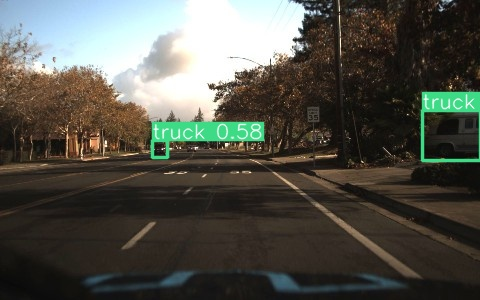

In [ ]:
Image('/content/kaggle/yolov5/runs/detect/exp/1478019955679801306.jpg')

In [ ]:
!python detect.py --weights yolov5m.pt --conf-thres 0.5 --line-thickness 2 --source "/content/kaggle/images/1478020427201770556.jpg"

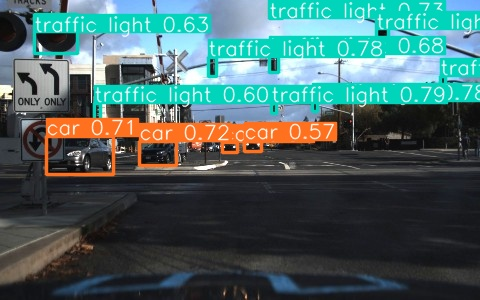

In [ ]:

Image('/content/kaggle/yolov5/runs/detect/exp4/1478020427201770556.jpg')

## Part 2


#### Make dataset.yml file for yolov5

In [ ]:
import os

# Define paths
output_folder = '/content/kaggle/yolov5/data'

# Create dataset.yaml content
dataset_yaml_content = """
# train and val and test data
train: /content/kaggle/yolov5/data/images/train/
val: /content/kaggle/yolov5/data/images/validation/
test: /content/kaggle/yolov5/data/images/test/

# number of classes
nc: 6

# Class name
names: [ 'nothing' , 'car', 'truck', 'pedestrian', 'bicyclist', 'light']
"""

# Save dataset.yaml file
os.makedirs(output_folder, exist_ok=True)
with open(os.path.join(output_folder, 'dataset.yaml'), 'w') as f:
    f.write(dataset_yaml_content)

print("dataset.yaml file created successfully.")

dataset.yaml file created successfully.


In [ ]:
!python train.py --img 480 --batch 16 --epochs 20 --data dataset.yaml --weights yolov5s.pt --cache

In [ ]:
# prompt: copy a folder from direction to another direction with shutil . if folder exist, then replace it updated folder

import shutil

# Define source and destination paths
source_folder = '/content/kaggle/yolov5/runs/train'
destination_folder = '/content/gdrive/MyDrive/kaggle/yolov5_train_results/runs/train/'

# Check if destination folder exists
if os.path.exists(destination_folder):
  # Remove the existing destination folder
  shutil.rmtree(destination_folder)

# Copy the source folder to the destination
shutil.copytree(source_folder, destination_folder)

print("Folder copied successfully.")


Folder copied successfully.


In [ ]:
# prompt: using thepast cell python code(imgshow(os.path.join(ROOT_DIR,'/content/kaggle/yolov8/ultralytics/runs/detect/train3/train_batch0.jpg'), width = 600)). display all image (jpg and png)

import os
from IPython.display import Image, display

# Get a list of all files in the directory
files = os.listdir('/content/kaggle/yolov5/runs/train/exp')

# Filter the list to only include JPG and PNG files
image_files = [file for file in files if file.endswith('.jpg') or file.endswith('.png')]

# Display each image
for image_file in image_files:
    display(Image(filename=os.path.join('/content/kaggle/yolov5/runs/train/exp', image_file)))



In [ ]:
!python train.py --img 480 --batch 16 --epochs 20 --data dataset.yaml --weights yolov5m.pt --cache

In [ ]:
# prompt: copy a folder from direction to another direction with shutil . if folder exist, then replace it updated folder

import shutil

# Define source and destination paths
source_folder = '/content/kaggle/yolov5/runs/train'
destination_folder = '/content/gdrive/MyDrive/kaggle/yolov5_train_results/runs/train/'

# Check if destination folder exists
if os.path.exists(destination_folder):
  # Remove the existing destination folder
  shutil.rmtree(destination_folder)

# Copy the source folder to the destination
shutil.copytree(source_folder, destination_folder)

print("Folder copied successfully.")


Folder copied successfully.


In [ ]:
# prompt: using thepast cell python code(imgshow(os.path.join(ROOT_DIR,'/content/kaggle/yolov8/ultralytics/runs/detect/train3/train_batch0.jpg'), width = 600)). display all image (jpg and png)

import os
from IPython.display import Image, display

# Get a list of all files in the directory
files = os.listdir('/content/kaggle/yolov5/runs/train/exp2')

# Filter the list to only include JPG and PNG files
image_files = [file for file in files if file.endswith('.jpg') or file.endswith('.png')]

# Display each image
for image_file in image_files:
    display(Image(filename=os.path.join('/content/kaggle/yolov5/runs/train/exp2', image_file)))



# yolov8

In [ ]:
# make a folder with name of "yolov8" in this direction '/content/kaggle/'

!mkdir /content/kaggle/yolov8


In [ ]:
ROOT_DIR = '/content/kaggle/yolov8'

In [ ]:
%cd {ROOT_DIR}

/content/kaggle/yolov8


In [ ]:
!git clone https://github.com/ultralytics/ultralytics.git

In [ ]:
%ls

ultralytics/


In [ ]:
%cd ultralytics

/content/kaggle/yolov8/ultralytics


In [ ]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'



In [ ]:
!pip install ultralytics


In [ ]:
%cd {ROOT_DIR}

/content/kaggle


In [ ]:
!pip install Ipython

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import Image as imgshow
import os

### make foldering dataset for yolov8 standard

In [ ]:
import os
import random
from concurrent.futures import ProcessPoolExecutor

# Define paths
images_folder = '/content/kaggle/images'
labels_folder = '/content/kaggle/labels'
train_folder = '/content/kaggle/yolov8/ultralytics/data/images/train/'
validation_folder = '/content/kaggle/yolov8/ultralytics/data/images/validation/'

# Get lists of images and labels
images = os.listdir(images_folder)
labels = os.listdir(labels_folder)

# Split images and labels into train and validation sets
split_ratio = 0.8
images_to_train = [image for image in images if random.random() < split_ratio]
images_to_validate = list(set(images) - set(images_to_train))
labels_to_train = [label for label in labels if label.split('.')[0] in images_to_train]  # Match labels to images
labels_to_validate = list(set(labels) - set(labels_to_train))

# Make sure destination folders exist
for folder in [train_folder, validation_folder]:
  os.makedirs(os.path.join(folder, 'images'), exist_ok=True)
  os.makedirs(os.path.join(folder, 'labels'), exist_ok=True)

# Define a function to copy a single image and label pair
def copy_file(source_image, source_label, destination_images, destination_labels):
  shutil.copyfile(os.path.join(images_folder, source_image), os.path.join(destination_images, source_image))
  shutil.copyfile(os.path.join(labels_folder, source_label), os.path.join(destination_labels, source_label))

# Use multiprocessing to copy files in parallel
with ProcessPoolExecutor() as executor:
  tasks = []

  # Prepare tasks for train set
  for image in images_to_train:
    label = image.replace('.jpg', '.txt')
    tasks.append(executor.submit(copy_file, image, label, os.path.join(train_folder, 'images'), os.path.join(train_folder, 'labels')))

  # Prepare tasks for validation set
  for image in images_to_validate:
    label = image.replace('.jpg', '.txt')
    tasks.append(executor.submit(copy_file, image, label, os.path.join(validation_folder, 'images'), os.path.join(validation_folder, 'labels')))

  # Wait for all tasks to finish
  for future in tasks:
    future.result()

print("File copying completed!")


File copying completed!


#### Make dataset.yml file for yolov8

In [ ]:
import os

# Define paths
output_folder = '/content/kaggle/yolov8/ultralytics/data'

# Create dataset.yaml content
dataset_yaml_content = """
# train and val and test data
train: /content/kaggle/yolov8/ultralytics/data/images/train/
val: /content/kaggle/yolov8/ultralytics/data/images/validation/
test: /content/kaggle/yolov8/ultralytics/data/images/test/

# number of classes
nc: 6

# Class name
names: [ 'nothing' , 'car', 'truck', 'pedestrian', 'bicyclist', 'light']
"""

# Save dataset.yaml file
os.makedirs(output_folder, exist_ok=True)
with open(os.path.join(output_folder, 'dataset.yaml'), 'w') as f:
    f.write(dataset_yaml_content)

print("dataset.yaml file created successfully.")

dataset.yaml file created successfully.


### Object detection

In [ ]:
!yolo task=detect mode=train model=yolov8s.pt data=/content/kaggle/yolov8/ultralytics/data/dataset.yaml epochs=20 imgsz=480

In [ ]:
# prompt: copy a folder from direction to another direction with shutil . if folder exist, then replace it updated folder

import shutil

# Define source and destination paths
source_folder = '/content/kaggle/yolov8/ultralytics/runs/detect'
destination_folder = '/content/gdrive/MyDrive/kaggle/yolov8_train_results/runs/detect/'

# Check if destination folder exists
if os.path.exists(destination_folder):
  # Remove the existing destination folder
  shutil.rmtree(destination_folder)

# Copy the source folder to the destination
shutil.copytree(source_folder, destination_folder)

print("Folder copied successfully.")


Folder copied successfully.


In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
# prompt: using thepast cell python code(imgshow(os.path.join(ROOT_DIR,'/content/kaggle/yolov8/ultralytics/runs/detect/train3/train_batch0.jpg'), width = 600)). display all image (jpg and png)

import os
from IPython.display import Image, display

# Get a list of all files in the directory
files = os.listdir('/content/kaggle/yolov8/ultralytics/runs/detect/train3/')

# Filter the list to only include JPG and PNG files
image_files = [file for file in files if file.endswith('.jpg') or file.endswith('.png')]

# Display each image
for image_file in image_files:
    display(Image(filename=os.path.join('/content/kaggle/yolov8/ultralytics/runs/detect/train3/', image_file)))

